# Simulating Membrane Potential

The simulation scripts described in this chapter are available at [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/blob/master/user_manual/source/HH_APprop.ipynb).

This chapter introduces the concept of simulating the electric potential
across a membrane in STEPS using a method that calculates electric potentials on tetrahedral meshes called 'E-Field' (see Hepburn I. et al. (2013) *Efficient calculation of the quasi-static electrical potential on a tetrahedral mesh. Front Comput Neurosci. DOI: 10.3389/fncom.2013.00129*).
We'll be introduced to new objects that
represent phenomena linked to the membrane potential simulation,
such as voltage-dependent channel transitions and currents across the membrane. We will
look at an example based on a very widely-used
model in computational neuroscience, the classical Hodgkin-Huxley model of the
action-potential, in molecular form. To demonstrate some useful techniques for
spatial simulations we will model action potential propagation in a simple mesh. As with previous chapters,
we will briefly introduce the model, then go through Python code used to run the
model in STEPS, with thorough descriptions where necessary.

We will start with spatial stochastic simulation in solvers 'Tetexact' ([steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact)) and 'TetOpSplit' ([steps.solver.TetOpSplit](API_solver.rst#steps.solver.TetOpSplit)), then discuss what modifications are necessary to run the
equivalent spatial deterministic solution in solver 'TetODE' ([steps.solver.TetODE](API_solver.rst#steps.solver.TetODE)).

## Markov gating scheme

While many readers may not be familiar with conversion of the classical Hodgkin-Huxley (HH)
model to a Markov gating scheme we will only give a brief description here, though there are many
sources a reader may consult for a more detailed description (for example Hille B. *Gating Mechanisms: Kinetic Thinking. In Ion Channels of Excitable Membranes, 3rd ed. Sinauer Associates, Sunderland, MA: 2001:583-589*).
In brief, conductances are converted to a population of individual channels (each with single-channel
conductance of typically 20pS), and each individual channel may exist in one of a number of
states with rates described of possible first-order transitions to other states. Certain assumptions,
such as that the the rate constants do not depend on the history of the system (a Markov process),
and with the simplification that states with the same number of 'open' and 'closed' gates behave
identically regardless of specific configuration, lead to gating schemes as shown in the two figures below
for the HH potassium and sodium channels respectively.



![](images/K.png)
 


 In this representation the potassium channel is described by 4 gates which may be in open or closed configuration. State n3, for example, means that any 3 of the 4 gates are in open state. Where all 4 gates are open (state n4) the channel may conduct a current- all other states are non-conducting states. 



![](images/Na.png)


The sodium channel is represented by 8 possible states- the m3h1 state is the conducting state.


The transition rates ($a_n$, $b_n$  for the potassium channel - $a_m$, $b_m$, $a_h$, $b_h$ for the sodium channel)
should be very familiar to anyone well-acquainted with the HH model:

\begin{equation}
   a_n = \frac{0.01\times(10-(V+65))}{\exp\left(\frac{10-(V+65)}{10}\right)-1}
\end{equation}

\begin{equation}
   b_n = 0.125\exp\left(\frac{-(V+65)}{80}\right)
\end{equation}

\begin{equation}
   a_m = \frac{0.1\times(25-(V+65))}{\exp\left(\frac{25-(V+65)}{10}\right)-1}
\end{equation}

\begin{equation}
   b_m = 4\exp\left(\frac{-(V+65)}{18}\right)
\end{equation}

\begin{equation}
   a_h = 0.07\exp\left(\frac{-(V+65)}{20}\right)
\end{equation}

\begin{equation}
   b_h = \frac{1}{\exp\left(\frac{30-(V+65)}{10}\right)+1}
\end{equation}

Where V is the potential across the membrane (in millivolts). Modelled as a stochastic process where each state is discretely populated, these functions form the basis of the propensity functions for each possible transition at any given voltage (here units are per millisecond). Voltage continuously changes during simulation, yet over a short period of time the change is small enough so that the transition rates may be considered constant and stochastic algorithms applied. The transition rates must then be updated when the voltage change becomes large enough to merit a reevaluation of these functions.

## Modelling solution

### Organisation of code

As in previous chapters we will go through code line-by-line from a script
used to run this simulation in STEPS, but this time without using the command prompt style.
Readers should note that actual indentation in the Python code and the indentation in the examples
here can be different, and indentation is very important in Python code.

The first thing to do is to import modules from STEPS that we need to run the simulation,
and assign them shorter names to reduce typing (for example `smodel` refers to ``steps.model``).
In addition we will make use of modules numpy, math, time and random to assist with the simulation:




In [1]:
import steps.model as smodel
import steps.geom as sgeom
import steps.rng as srng
import steps.solver as ssolver
import steps.utilities.meshio as meshio
import numpy
import math
import time
from random import *
from __future__ import print_function # for backward compatibility with Py2


Next we define some parameters for the simulation, which are intended to remain constant throughout
the script. We start with the potassium channel and define the single-channel conductance, channel
density and reversal potential, keeping to a conductance to 0.036 S/cm2 (see [Simulation with Tetexact](memb_pot.ipynb#Simulation-with-Tetexact) for more on converting continuous conductance to discrete conductance):




In [2]:
# Potassium single-channel conductance
K_G = 20.0e-12 # Siemens

# Potassium channel density
K_ro = 18.0e12 # per square meter

# Potassium reversal potential
K_rev = -77e-3 # volts


The first thing to note is that, as usual in STEPS, units are s.i., which means in the above example the single channel conductance is given in Siemens and
the reversal potential for the ohmic current is in volts.

Similarly, we define parameters for the sodium channel, also choosing a single-channel conductance
of 20pS:




In [3]:
# Sodium single-channel conductance
Na_G = 20.0e-12 # Siemens

# Sodium channel density
Na_ro = 60.0e12 # per square meter

# Sodium reversal potential
Na_rev = 50e-3 # volts


The HH model also includes a leak conductance, which may also be discretised (although another option is to use solver function [steps.solver.Tetexact.setMembRes](API_solver.rst#steps.solver.Tetexact.setMembRes)). The overall conductance is
small compared to maximal potassium and sodium conductances, but we choose a similar channel density to give
a good spatial spread of the conductance, which means a fairly low single-channel conductance:




In [4]:
# Leak single-channel conductance
L_G = 0.3e-12 # Siemens

# Leak density
L_ro = 10.0e12 # per square meter

# Leak reversal potential
leak_rev = -54.4e-3 # volts


The next parameters require a little explanation. Taking the potassium conductance as an example, the
potassium density will convert to a discrete number of channels that will give (approximately) our intended
maximal conductance of 0.036 S/$cm^2$. In the molecular sense, this means that if all potassium channels
are in the 'open' conducting state then we will reach the maximal conductance. However, in fact
each individual channel can be in any one of 5 states (including the conducting state) (see figure above) and these states are
described by separate objects in the STEPS simulation (as we will see later), where the sum of populations of each state should
be equal to the total number of channels. For example, if the surface of the mesh is 100 square microns
by the above density we expect to have a total of 1800 potassium channels in the simulation but at some time
we might have e.g. 400 in the n0 state, 700 in the n1 state, 500 in the n2 state, 150 in the n3 state
and 50 in the conducting n4 state, and the total at any time will be equal to 1800.

So we intend to initialise our populations of channel states to some starting value. The details of how to
calculate the initial condition will not be given here, but the factors used here are steady-state approximations for
the HH model at an initial potential of -65mV. We then give a table of fractional channel state populations (which
add up to a value of 1). For each channel state the factor multiplied by the channel density and the surface area
of the mesh will give our initial population of channels in that state:




In [5]:
# A table of potassium channel population factors:
# n0, n1, n2, n3, n4
K_facs = [ 0.21768, 0.40513, 0.28093, 0.08647, 0.00979 ]

# A table of sodium channel population factors
# m0h0, m1h0, m2h0, m3h0, m0h1, m1h1, m2h1, m3h1:
Na_facs = [ 0.34412, 0.05733, 0.00327, 6.0e-05,\
            0.50558, 0.08504, 0.00449, 0.00010 ]


We now define some more important parameters for our simulation. The first is temperature assumed for
the gating kinetics, which we will give in units of degrees celsius but is not directly used in simulation
(as we will see). The second is a current clamp that we intend for one end of the mesh. The third is a
voltage-range for simulation. These parameters will all be discussed in more detail later:




In [6]:
# Temperature for gating kinetics
celsius = 20.0

# Current clamp
Iclamp = 50.0e-12 # amps

# Voltage range for gating kinetics in Volts
Vrange = [-100.0e-3, 50e-3, 1e-4]


Finally we set some simulation control parameters, the number of 'time-points' to run and
the 'time-step' at which we will record data. So we will run for 4ms in increments of 0.1ms:




In [7]:
# The number of simulation time-points
N_timepoints = 41

# The simulation dt
DT_sim = 1.0e-4 # seconds

### Model specification

We move on to the biochemical model description. This is quite different from previous chapters, with
new objects to look at, which are important building blocks of any simulation that includes
voltage-dependent processes in STEPS.

To start, we create a Model container object ([steps.model.Model](API_model.rst#steps.model.Model)) and one surface system
([steps.model.Surfsys](API_model.rst#steps.model.Surfsys)), with no volume system necessary for this relatively simple model:




In [8]:
mdl = smodel.Model()
ssys = smodel.Surfsys('ssys', mdl)


To make our potassium, sodium and leak channels we need to use two new objects. The [steps.model.ChanState](API_model.rst#steps.model.ChanState)
objects are used to describe each separate channel state, and [steps.model.Chan](API_model.rst#steps.model.Chan) objects group a set of
channel states together to form a channel. At present the role of Channel objects ([steps.model.Chan](API_model.rst#steps.model.Chan))
is mainly conceptual and not functional, with the ChannelState objects ([steps.model.ChanState](API_model.rst#steps.model.ChanState))
playing the important roles in simulation: for example, voltage-dependent transitions occur between channel states
and a channel current object is associated with a channel state, both of which we will see later. As discussed in Hepburn I. et al. (2013) *Efficient calculation of the quasi-static electrical potential on a tetrahedral mesh. Front Comput Neurosci. DOI: 10.3389/fncom.2013.00129*, Channel states also include
the same functionality as [steps.model.Spec](API_model.rst#steps.model.Spec) objects and so can interact with other molecules and diffuse on the surface
or in a volume, however there is no example of that functionality in this model.

The code to create the potassium channel looks like this:




In [9]:
# Potassium channel
K = smodel.Chan('K', mdl)
K_n0 = smodel.ChanState('K_n0', mdl, K)
K_n1 = smodel.ChanState('K_n1', mdl, K)
K_n2 = smodel.ChanState('K_n2', mdl, K)
K_n3 = smodel.ChanState('K_n3', mdl, K)
K_n4 = smodel.ChanState('K_n4', mdl, K)


[steps.model.ChanState](API_model.rst#steps.model.ChanState) object construction looks quite similar to that for [steps.model.Spec](API_model.rst#steps.model.Spec) objects,
with the difference that, as well as the usual string identifier and [steps.model.Model](API_model.rst#steps.model.Model) container object
arguments, the constructor also expects to see a reference to a [steps.model.Chan](API_model.rst#steps.model.Chan) object that conceptually
groups the channel states together. It is obvious to see here which channel configuration each
state is intended to represent in this model.

Similarly we create the sodium channel objects:




In [10]:
Na = smodel.Chan('Na', mdl)
Na_m0h0 = smodel.ChanState('Na_m0h0', mdl, Na)
Na_m1h0 = smodel.ChanState('Na_m1h0', mdl, Na)
Na_m2h0 = smodel.ChanState('Na_m2h0', mdl, Na)
Na_m3h0 = smodel.ChanState('Na_m3h0', mdl, Na)
Na_m0h1 = smodel.ChanState('Na_m0h1', mdl, Na)
Na_m1h1 = smodel.ChanState('Na_m1h1', mdl, Na)
Na_m2h1 = smodel.ChanState('Na_m2h1', mdl, Na)
Na_m3h1 = smodel.ChanState('Na_m3h1', mdl, Na)


and also the leak channel objects, which only exist in conducting state:




In [11]:
# Leak channel
L = smodel.Chan('L', mdl)
Leak = smodel.ChanState('Leak', mdl, L)


We move on to describing the transitions between channel states. Firstly, we describe the transition rates
in the model, as described in [Markov gating scheme](memb_pot.ipynb#Markov-gating-scheme), and we do so for each using a lambda expressions, which is
a shorthand way to define a function object in Python. We can use any callable function here (as will be
explained later) so we could just as easily use the more familiar `def` syntax if we wanted to. We also introduce
temperature dependence and use the previously defined `celsius` variable to find `thi` at 20 degrees celsius:





In [12]:
# Temperature dependence
thi = math.pow(3.0, ((celsius-6.3)/10.0))
_a_n = lambda mV: thi*((0.01*(10-(mV+65.))/(math.exp((10-(mV+65.))/10.)-1)))
_b_n = lambda mV: thi*((0.125*math.exp(-(mV+65.)/80.)))
_a_m = lambda mV: thi*((0.1*(25-(mV+65.))/(math.exp((25-(mV+65.))/10.)-1)))
_b_m = lambda mV: thi*((4.*math.exp(-(mV+65.)/18.)))
_a_h = lambda mV: thi*((0.07*math.exp(-(mV+65.)/20.)))
_b_h = lambda mV: thi*((1./(math.exp((30-(mV+65.))/10.)+1)))


We should bear in mind that these functions will expect a voltage to be given in units of millivolts, and
will return the transition rate in unit of /ms.

To define voltage-dependent channel transitions we use a new STEPS object, the 'Voltage-dependent surface reaction'
([steps.model.VDepSReac](API_model.rst#steps.model.VDepSReac)). This object may be used to define any reaction in STEPS that is voltage-dependent, which
often involves 1st-order voltage-dependent transitions between different channel states, but also supports
higher order interactions which may include interactions between volume-diffusing molecules and surface-bound molecules
and thus allows modelling of, for example, voltage-dependent channel block. Because all
of these processes are only permitted to occur on a surface and not in a volume, we choose the term
'voltage-dependent surface reaction'.
The syntax of creating this object, therefore, shares similarities with [steps.model.SReac](API_model.rst#steps.model.SReac), but with some
important differences. Let's look at a first example:




In [13]:
Kn0n1 = smodel.VDepSReac('Kn0n1', ssys, slhs = [K_n0], srhs = [K_n1], \
                         k=lambda V: 1.0e3 *4.*_a_n(V*1.0e3), vrange = [-100.0e-3, 50e-3, 1e-4])



The first few arguments to the [steps.model.VDepSReac](API_model.rst#steps.model.VDepSReac) constructor are identical to those for
[steps.model.SReac](API_model.rst#steps.model.SReac): in order, a string-identifier is required (which must be unique amongst all objects of the
same type), a reference to a [steps.model.Surfsys](API_model.rst#steps.model.Surfsys) object, a list of reactants- the 'left-hand side' arguments
(which may exist in the 'inner' volume, the surface, or the 'outer' volume, but not in both volumes) and a list of products- the 'right-hand side' arguments. The syntax up to this point follows exactly as described for
[steps.model.SReac](API_model.rst#steps.model.SReac) in [Surface-Volume Reactions (Example: IP3 Model)](ip3.ipynb), with one noteworthy difference: now the reactants and products may be
[steps.model.ChanState](API_model.rst#steps.model.ChanState) objects, as well as [steps.model.Spec](API_model.rst#steps.model.Spec) objects, or a mixture of both. Indeed,
in the context of reactions in STEPS (voltage-dependent or otherwise) [steps.model.ChanState](API_model.rst#steps.model.ChanState) objects
behave exactly like [steps.model.Spec](API_model.rst#steps.model.Spec) objects, with the only difference between the two being that
[steps.model.ChanState](API_model.rst#steps.model.ChanState) objects support additional functionality, namely the ability to conduct current, as we
will see later.
The other arguments, keyword arguments `k` and `vrange` require some explanation. The macroscopic reaction 'constant' is
of course now not a constant at all, but instead depends on voltage. To describe the voltage-dependence we pass
a function to argument `k` which returns the reaction rate as a function of voltage. We tell STEPS to evaluate this
function over a voltage range, which we choose so as to easily cover all voltages we expect the membrane potential to
reach during the simulation. As with other reaction objects, all units are specified as s.i. units, with the exception of
higher-order reactions which are based on Molar units. Since this is a 1st-order reaction we must ensure that the
function passed to the `k` argument returns in units of /second over the range of potentials passed in units of Volts.
Since this particular voltage-dependent surface reaction object is clearly intended to model the forward n0 to n1
transition, as shown in the figure above, we require a factor of 4 to be applied to the `_a_n` function to cover each possible 0 to 1 transition. To achieve this our
function to `k` is:




In [14]:
k = lambda V: 1.0e3 *4.*_a_n(V*1.0e3)


where the unit conversions should be clear (recall `_a_n` expects an argument in mV units, and returns /ms).
The `vrange` argument requires the voltage-range to evaluate the rate-function as a Python sequence in the order
of: minimum voltage, maximum voltage, voltage-step. We should choose the voltage range to cover
what we expect from the simulation, but not by too much since a smaller range gives faster performance, and the voltage-step
should be chosen to give only a small error from linear interpolation between voltage-points. It is a very important point
that if, during a simulation, the membrane potential goes outside the voltage range for any voltage-dependent surface
reaction object located in that membrane the simulation will fail.
In our example we choose a voltage range of -100mV to +50mV, and tell STEPS to evaluate the voltage every 0.1mV, so
the `vrange` argument is:




In [15]:
vrange = [-100.0e-3, 50e-3, 1e-4]


In the 'Kn0n1' example the sequence of voltages was given directly to the `vrange` argument, but in fact at the beginning
of our script we defined a voltage-range as list `Vrange`, which we pass to all future VDepSreac objects we create in
this script. The rest of our voltage-dependent channel transitions for the Potassium channel are:




In [16]:
Kn1n2 = smodel.VDepSReac('Kn1n2', ssys, slhs = [K_n1], srhs = [K_n2], \
    k=lambda V: 1.0e3 *3.*_a_n(V*1.0e3), vrange = Vrange)
Kn2n3 = smodel.VDepSReac('Kn2n3', ssys, slhs = [K_n2], srhs = [K_n3], \
    k=lambda V: 1.0e3 *2.*_a_n(V*1.0e3), vrange = Vrange)
Kn3n4 = smodel.VDepSReac('Kn3n4', ssys, slhs = [K_n3], srhs = [K_n4], \
    k=lambda V: 1.0e3 *1.*_a_n(V*1.0e3), vrange = Vrange)

Kn4n3 = smodel.VDepSReac('Kn4n3', ssys, slhs = [K_n4], srhs = [K_n3], \
    k=lambda V: 1.0e3 *4.*_b_n(V*1.0e3), vrange = Vrange)
Kn3n2 = smodel.VDepSReac('Kn3n2', ssys, slhs = [K_n3], srhs = [K_n2], \
    k=lambda V: 1.0e3 *3.*_b_n(V*1.0e3), vrange = Vrange)
Kn2n1 = smodel.VDepSReac('Kn2n1', ssys, slhs = [K_n2], srhs = [K_n1], \
    k=lambda V: 1.0e3 *2.*_b_n(V*1.0e3), vrange = Vrange)
Kn1n0 = smodel.VDepSReac('Kn1n0', ssys, slhs = [K_n1], srhs = [K_n0], \
    k=lambda V: 1.0e3 *1.*_b_n(V*1.0e3), vrange = Vrange)


The voltage-dependent surface reactions for the Sodium channel follow. Since there are 20 different possible
transitions (see figure above) we need to create 20 [steps.model.VDepSReac](API_model.rst#steps.model.VDepSReac) objects:




In [17]:
Na_m0h1_m1h1 = smodel.VDepSReac('Na_m0h1_m1h1', ssys, \
    slhs=[Na_m0h1], srhs=[Na_m1h1], \
        k=lambda V:1.0e3*3.*_a_m(V*1.0e3), vrange=Vrange)
Na_m1h1_m2h1 = smodel.VDepSReac('Na_m1h1_m2h1', ssys, \
    slhs=[Na_m1h1], srhs=[Na_m2h1], \
        k=lambda V:1.0e3*2.*_a_m(V*1.0e3), vrange=Vrange)
Na_m2h1_m3h1 = smodel.VDepSReac('Na_m2h1_m3h1', ssys, \
    slhs=[Na_m2h1], srhs=[Na_m3h1], \
        k=lambda V:1.0e3*1.*_a_m(V*1.0e3), vrange=Vrange)

Na_m3h1_m2h1 = smodel.VDepSReac('Na_m3h1_m2h1', ssys, \
    slhs=[Na_m3h1], srhs=[Na_m2h1], \
        k=lambda V:1.0e3*3.*_b_m(V*1.0e3), vrange=Vrange)
Na_m2h1_m1h1 = smodel.VDepSReac('Na_m2h1_m1h1', ssys, \
    slhs=[Na_m2h1], srhs=[Na_m1h1], \
        k=lambda V:1.0e3*2.*_b_m(V*1.0e3), vrange=Vrange)
Na_m1h1_m0h1 = smodel.VDepSReac('Na_m1h1_m0h1', ssys, \
    slhs=[Na_m1h1], srhs=[Na_m0h1], \
        k=lambda V:1.0e3*1.*_b_m(V*1.0e3), vrange=Vrange)

Na_m0h0_m1h0 = smodel.VDepSReac('Na_m0h0_m1h0', ssys, \
    slhs=[Na_m0h0], srhs=[Na_m1h0], \
        k=lambda V:1.0e3*3.*_a_m(V*1.0e3), vrange=Vrange)
Na_m1h0_m2h0 = smodel.VDepSReac('Na_m1h0_m2h0', ssys, \
    slhs=[Na_m1h0], srhs=[Na_m2h0], \
        k=lambda V:1.0e3*2.*_a_m(V*1.0e3), vrange=Vrange)
Na_m2h0_m3h0 = smodel.VDepSReac('Na_m2h0_m3h0', ssys, \
    slhs=[Na_m2h0], srhs=[Na_m3h0], \
        k=lambda V:1.0e3*1.*_a_m(V*1.0e3), vrange=Vrange)

Na_m3h0_m2h0 = smodel.VDepSReac('Na_m3h0_m2h0', ssys, \
    slhs=[Na_m3h0], srhs=[Na_m2h0], \
        k=lambda V:1.0e3*3.*_b_m(V*1.0e3), vrange=Vrange)
Na_m2h0_m1h0 = smodel.VDepSReac('Na_m2h0_m1h0', ssys, \
    slhs=[Na_m2h0], srhs=[Na_m1h0], \
        k=lambda V:1.0e3*2.*_b_m(V*1.0e3), vrange=Vrange)
Na_m1h0_m0h0 = smodel.VDepSReac('Na_m1h0_m0h0', ssys, \
    slhs=[Na_m1h0], srhs=[Na_m0h0], \
        k=lambda V:1.0e3*1.*_b_m(V*1.0e3), vrange=Vrange)

Na_m0h0_m0h1 = smodel.VDepSReac('Na_m0h0_m0h1', ssys, \
    slhs=[Na_m0h0], srhs=[Na_m0h1], \
        k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)
Na_m1h0_m1h1 = smodel.VDepSReac('Na_m1h0_m1h1', ssys, \
    slhs=[Na_m1h0], srhs=[Na_m1h1], \
        k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)
Na_m2h0_m2h1 = smodel.VDepSReac('Na_m2h0_m2h1', ssys, \
    slhs=[Na_m2h0], srhs=[Na_m2h1], \
        k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)
Na_m3h0_m3h1 = smodel.VDepSReac('Na_m3h0_m3h1', ssys, \
    slhs=[Na_m3h0], srhs=[Na_m3h1], \
        k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)

Na_m0h1_m0h0 = smodel.VDepSReac('Na_m0h1_m0h0', ssys, \
    slhs=[Na_m0h1], srhs=[Na_m0h0], \
        k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)
Na_m1h1_m1h0 = smodel.VDepSReac('Na_m1h1_m1h0', ssys, \
    slhs=[Na_m1h1], srhs=[Na_m1h0], \
        k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)
Na_m2h1_m2h0 = smodel.VDepSReac('Na_m2h1_m2h0', ssys, \
    slhs=[Na_m2h1], srhs=[Na_m2h0], \
        k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)
Na_m3h1_m3h0 = smodel.VDepSReac('Na_m3h1_m3h0', ssys, \
    slhs=[Na_m3h1], srhs=[Na_m3h0], \
        k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)


The final part of our model specification is to add currents. Presently in STEPS we have the choice of two types of current that have quite different behaviour: Ohmic currents- which are represented by [steps.model.OhmicCurr](API_model.rst#steps.model.OhmicCurr) objects- and currents based on the GHK flux equation- represented by [steps.model.GHKcurr](API_model.rst#steps.model.GHKcurr) objects. Since the Hodgkin-Huxley model utilises Ohmic currents we only need to concern ourselves with those objects here.

The assumption made in STEPS is that Ohmic current objects are used to model currents of ions that play no other important role in the system other than in membrane excitability, and so it is not necessary to add, in this example, ions of sodium and potassium diffusing both extra- and intra-cellularly. Because of the relatively large concentration of these ions simulating diffusion would be incredibly slowing to simulations with no perceptible benefit to accuracy. It is due to these arguments that an Ohmic current in STEPS will not result in transport of ions between compartments. The GHK current objects are able to model ion transport and so should always be used when modelling currents of important signalling ions, a good example of which for many systems is calcium.

Because STEPS is primarily a discrete simulator the Current objects in STEPS are based on single-channel currents. A [steps.model.OhmicCurr](API_model.rst#steps.model.OhmicCurr), applied to a specific [steps.model.ChanState](API_model.rst#steps.model.ChanState) object will result in an Ohmic current through every single Channel in that specific state located in the Membrane (which we will create later) at any given time. Therefore, to create an Ohmic current in STEPS we need to pass information as to which Channel state the current will be applied to, as well as its single-channel conductance to this current, along with the reversal potential. As usual in STEPS all units are based on s.i. units, and so the single-channel conductance unit is Siemens and reversal potential unit is volts.

The [steps.model.OhmicCurr](API_model.rst#steps.model.OhmicCurr) constructor expects 5 arguments: a string identifier (as usual in STEPS this must be unique amongst other Ohmic current objects), a reference to a [steps.model.Surfsys](API_model.rst#steps.model.Surfsys) object, a reference to a [steps.model.ChanState](API_model.rst#steps.model.ChanState) to which this current applies (`chanstate` argument), a single-channel conductance (`g` argument), and a reversal potential  (`erev` argument). At the top of our script we already defined conductance and reversal potential for all of our channels in this simulation, i.e. the potassium single-channel conductance ``K_G = 20.0e-12`` Siemens and reversal potential ``K_rev = -77e-3`` volts, the sodium single-channel conductance ``Na_G = 20.0e-12`` Siemens and reversal potential ``Na_rev = 50e-3`` volts, the leak single-channel conductance ``L_G = 0.3e-12`` Siemens and reversal potential ``leak_rev = -54.4e-3`` volts, so we use these values when creating the Ohmic current objects. The conducting states of the potassium, sodium and leak currents respectively are ``K_n4``, ``Na_m3h1`` and `Leak`:




In [18]:
OC_K = smodel.OhmicCurr('OC_K', ssys, chanstate=K_n4, g=K_G, erev=K_rev)
OC_Na = smodel.OhmicCurr('OC_Na', ssys, chanstate=Na_m3h1, g=Na_G, erev=Na_rev)
OC_L = smodel.OhmicCurr('OC_L', ssys, chanstate=Leak, g=L_G, erev=leak_rev)


Now in the STEPS simulation when, for example, the number of potassium channels in state K_n4 is non-zero a potassium conductance will exist equal to the population of K_n4 channel states multiplied by the single channel conductance, and a current will be calculated depending on the local voltage relative to the given reversal potential.

### Geometry specification

With the model completed we move on to geometry specification. To simulate action potential propagation we'll demonstrate the rather unusual case of using a long cuboid mesh whereas other simulators may typically assume cylindrical geometry. This is partly to demonstrate that the only restriction on geometry used for the membrane potential calculation in STEPS is that it can be represented by a tetrahedral mesh. Since tetrahedral meshes are capable of representing real cellular geometry with high accuracy this opens up many interesting applications, yet for this example we'll stick with a rather basic shape. As in previous sections we'll import a mesh in Abaqus format, which represents a cuboid of length 1000µm in the z-axis, and a diameter of 0.44µm (which is an equivalent cylindrical diamter of 0.5µm) in the x and y axes (as shown in the figure below) :




In [19]:
mesh = meshio.importAbaqus('meshes/axon_cube_L1000um_D443nm_equiv0.5_19087tets.inp', 1e-6)[0]

Reading Abaqus file...
Number of nodes imported:  8318
Number of tetrahedrons imported:  19087
Number of triangles imported:  0
creating Tetmesh object in STEPS...
Tetmesh object created.



![](images/HHmesh.png)




In the figure above we show a portion of the tetrahedral mesh representing a cuboid of length 1000µm oriented along the z-axis.


The following section of code will not be explained in detail, but simply serves two purposes. Firstly, to find the vertices at one end of the cuboid in which a current pulse will be applied (which will be stored in list `injverts`)- since the long axis of the cuboid in the z-axis these will be the minimum z vertices. Secondly, to find the corresponding triangles on that face, which will be excluded from the membrane (stored in list `facetris`) since this end is intended to be an 'open' end:




In [20]:
# Find the vertices for the current clamp and store in a list
injverts = []
for i in range(mesh.nverts):
    if ((mesh.getVertex(i)[2] < (mesh.getBoundMin()[2]+0.1e-6))):
        injverts.append(i)
print("Found ", injverts.__len__(), "I_inject vertices")

facetris = []
for i in range(mesh.ntris):
    tri = mesh.getTri(i)
    if ((tri[0] in injverts) and (tri[1] in injverts) and (tri[2] in injverts)):
        facetris.append(i)
print("Found ", facetris.__len__(), "triangles on bottom face")

Found  4 I_inject vertices
Found  2 triangles on bottom face



Now we will use a mesh function to find all the triangles on the surface of the mesh and exclude those on the bottom face:




In [21]:
memb_tris = list(mesh.getSurfTris())

# Remove triangles on bottom face from membrane triangles
for t in facetris: memb_tris.remove(t)


The following section of code, which will also not be described in full detail, simply serves to `bin` the surface triangles by distance along the z-axis and to store the total area of the bins, which will be used later in the script to convert recorded current to a current density (current per unit area):




In [22]:
# Bin the surface triangles for recording current
bins_n = 100
memb_tris_binned = [None]*bins_n
mtb_area = numpy.zeros(bins_n)

# In m
bin_dz = 1000.0e-6/bins_n

# The centre positions of the bins
bin_pos = numpy.arange((bin_dz/2.0), 1000e-6, bin_dz)

for m in range(bins_n): memb_tris_binned[m]=[]

# Bin the triangles
for t in memb_tris:
    barycz = mesh.getTriBarycenter(t)[2]
    idx = 0
    for p in bin_pos:
        if (barycz >= p-(bin_dz/2.0) and barycz < p+(bin_dz/2.0)):
            memb_tris_binned[idx].append(t)
            mtb_area[idx]+=(mesh.getTriArea(t)*1.0e12)
            break
        idx +=1


The final piece of geometry manipulation is to find a point at every 10µm along the z-axis at which to record potential. In STEPS it is possible to record potential anywhere in the membrane or conduction volume and from vertices, triangles and tetrahedrons. Here we intend to record the potential at intracellular tetrahedrons along the centre of the cuboid, and so find their indices and store in numpy array ``pot_tet``:




In [23]:
# The points along (z) axis at which to record potential
pot_pos = numpy.arange(mesh.getBoundMin()[2], mesh.getBoundMax()[2], 10e-6)
pot_n = len(pot_pos)

pot_tet = numpy.zeros(pot_n, dtype = 'uint')

i=0
for p in pot_pos:
    # Axis is aligned with z-axis
    pot_tet[i] = mesh.findTetByPoint([0.0, 0.0, pot_pos[i]])
    i=i+1


Now, much like in previous chapters, we will create a compartment which simply consists of all tetrahedrons in the mesh, and a surface patch which consists of all surface triangles (except those on the minimum z face), which we found earlier and stored in list ``memb_tris``:




In [24]:
# Create cytosol compartment
cyto = sgeom.TmComp('cyto', mesh, range(mesh.ntets))

# Create the patch and associate with surface system 'ssys'
patch = sgeom.TmPatch('patch', mesh, memb_tris, cyto)
patch.addSurfsys('ssys')


And now we create a new and very important object for the membrane potential calculation, the 'membrane' itself. The membrane object, [steps.geom.Memb](API_geom.rst#steps.geom.Memb), simply consists of one or more patch objects which must together form one continuos surface, although the membrane may be 'open' or 'closed' ('closed' means all member triangles are directly connected to 3 other membrane triangles and so form a closed surface, and 'open' means some triangles have fewer than 3 neighbours and so the surface contains holes). Any channels that exist in the patch(es) that comprise(s) the membrane are available to conduct a current (specified by [steps.model.OhmicCurr](API_model.rst#steps.model.OhmicCurr) or [steps.model.GHKcurr](API_model.rst#steps.model.GHKcurr) objects). The INNER compartment(s) to the membrane patches will comprise the 'conduction volume' representing the intracellular region. The potential at all vertices in the membrane and conduction volume will be calculated and will vary with any channel, capacitive or externally applied currents, relative to the (earthed) extracellular region.

Where the extracellular space is included in simulations the membrane may be comprised of internal mesh triangles, but for this relatively simple model the membrane is formed from triangles on the surface of the mesh and is comprised of only one patch. This patch contains an inner compartment consisting of all tetrahedrons in the mesh, which will form the conduction volume. So we create the membrane:




In [25]:
# Create the membrane across which the potential will be solved
membrane = sgeom.Memb('membrane', mesh, [patch], opt_method = 1)


The [steps.geom.Memb](API_geom.rst#steps.geom.Memb) constructor requires a string identifier argument and a reference to a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object plus a list of the composite [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) objects (here there in only one), and finally an optional argument named ``opt_method``. This allows the choice of a method for optimization of the ordering of vertices in the membrane and conduction volume, which is essential to produce an efficient calculation, as discussed in Hepburn I. et al. (2013) *Efficient calculation of the quasi-static electrical potential on a tetrahedral mesh. Front Comput Neurosci. DOI: 10.3389/fncom.2013.00129*. Two methods are presently available: 1) a fast ordering of vertices by their position along the principle axis, which is suitable if one axis is much longer than an other (as is the case here) and 2) a slower breadth-first tree iteration, which produces a similar result to method (1) in cable-like structures but offers a significant improvement to simulation efficiency in complex geometries. Although the initial search for (2) can be slow it is possible to save an optimisation in a file for a specific membrane with solver function  [steps.solver.Tetexact.saveMembOpt](API_solver.rst#steps.solver.Tetexact.saveMembOpt), and this optimisation file can then be supplied as an argument to the [steps.geom.Memb](API_geom.rst#steps.geom.Memb) constructor, so each optimisation for any given membrane need only be found once. However, since this example uses a cable-like mesh we can use the faster principle-axis ordering method, though method (2) is recommended when working with complex, realistic geometries.

There is also an optional boolean argument `verify`, which defaults to False, but if True will verify that the membrane is a suitable surface for the potential calculation- although this verification can take rather a long time for larger meshes, so should only be used when one is not confident in the suitability of the membrane.

### Simulation with Tetexact

As always for a stochastic simulation in STEPS, we create the random number generator and provide a random initial seed based on the current time, here with 10,000 possible unique values:




In [26]:
# Create the random number generator
r = srng.create('mt19937',512)
r.initialize(int(time.time()%10000))


And with our model, geometry and random number generator created we are ready to create the solver object. The membrane potential calculation in STEPS is an extension to the [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) and [steps.solver.TetODE](API_solver.rst#steps.solver.TetODE) solvers, and creating the solver is much like in previous mesh-based examples, with arguments to the constructor of a [steps.model.Model](API_model.rst#steps.model.Model) object, a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object and a [steps.rng.RNG](API_rng.rst#steps.rng.RNG) object in that order, plus a simple boolean flag that switches on the membrane potential calculation when set to True (and defaults to False):




In [27]:
# Create solver object
sim = ssolver.Tetexact(mdl, mesh, r, True)


If requested to perform the membrane potential calculation (with the boolean argument set to True) a Tetexact solver requires one (and currently only one) [steps.geom.Memb](API_geom.rst#steps.geom.Memb) to exist within the geometry description, and will therefore fail to be created if such an object does not exist.

With the [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) solver successfully created, with the membrane potential calculation included, it is time to set the simulation initial conditions. Much like in previous examples, this requires injecting molecules into a specific location. In this case we wish to inject a number of molecules represented by [steps.model.ChanState](API_model.rst#steps.model.ChanState) objects in the model description into the membrane surface represented by a [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) object in the geometry description. As we will see, at the solver stage the Channel State objects behave just like Species objects and any solver method previously used for Species objects may be used for Channel State objects, such as [steps.solver.Tetexact.setPatchCount](API_solver.rst#steps.solver.Tetexact.setPatchCount), [steps.solver.Tetexact.setCompConc](API_solver.rst#steps.solver.Tetexact.setCompConc) and so on.

At this point we should pause to look at how to specify conductance in STEPS models. Conductance in STEPS comes from [steps.model.OhmicCurr](API_model.rst#steps.model.OhmicCurr) objects, which provide a single-channel conductance that will be applied to any Channel State molecule to which that conductance in mapped. For example, recall in this model that we created an Ohmic Current called ``OC_K`` to represent the potassium current in the simulation, which will apply to Channel State ``K_n4``, with a single-channel conductance of 20 pS and reversal potential of -77mV, with this statement:




    OC_K = smodel.OhmicCurr('OC_K', ssys, chanstate=K_n4, g=20.0e-12, erev=-77e-3)


The overall potassium conductance in the simulation at any time will be equal to the number of ``K_n4`` Channel States in existence multiplied by the single-channel conductance, with a maximum conductance equal to the highest possible number of ``K_n4`` Channel States (the total number of potassium channels).

Other simulators may use different methods from STEPS to specify conductance, and many modellers may be more comfortable working with conductance per unit area, so some care should be taken with the conversion for STEPS models. This typically involves multiplying conductance per unit area by the membrane area to find overall conductance, then injecting the correct amount of channels into the membrane in STEPS to represent this conductance, depending on the single-channel conductance. Since the conducting channels are discrete in STEPS there may be a small discrepancy from the continuous value.

Recall we have specified potassium channel density, ``K_ro``, as 18 per square micron and sodium channel density, ``Na_ro``, as 60 per square micron, previously in our script with statements:




    K_ro = 18.0e12 # per square meter
    Na_ro = 60.0e12 # per square meter


when multiplied by single-channel conductance to give maximum potassium conductance of 0.036 Siemens per square cm and sodium conductance of 0.120 Siemens per square cm. So when injecting our channels in STEPS we simply need to multiply these densities by the surface area of the membrane to find the number to inject. An added complication for this model is that we want to inject steady-state initial conditions, so all channel states have some initial non-zero proportion, which we specified previously in lists ``K_facs`` and ``Na_facs`` (and we will not go into the derivation of the steady-state factors here).

So to inject our channels, first we find the membrane surface area, which is the same as the area of its only constituent patch:




In [28]:
surfarea = sim.getPatchArea('patch')


And call solver method [steps.solver.Tetexact.setPatchCount](API_solver.rst#steps.solver.Tetexact.setPatchCount) for every Channel State in the model (including leak) to set the initial number:




In [29]:
sim.setPatchCount('patch', 'Na_m0h0', Na_ro*surfarea*Na_facs[0])
sim.setPatchCount('patch', 'Na_m1h0', Na_ro*surfarea*Na_facs[1])
sim.setPatchCount('patch', 'Na_m2h0', Na_ro*surfarea*Na_facs[2])
sim.setPatchCount('patch', 'Na_m3h0', Na_ro*surfarea*Na_facs[3])
sim.setPatchCount('patch', 'Na_m0h1', Na_ro*surfarea*Na_facs[4])
sim.setPatchCount('patch', 'Na_m1h1', Na_ro*surfarea*Na_facs[5])
sim.setPatchCount('patch', 'Na_m2h1', Na_ro*surfarea*Na_facs[6])
sim.setPatchCount('patch', 'Na_m3h1', Na_ro*surfarea*Na_facs[7])

sim.setPatchCount('patch', 'K_n0', K_ro*surfarea*K_facs[0])
sim.setPatchCount('patch', 'K_n1', K_ro*surfarea*K_facs[1])
sim.setPatchCount('patch', 'K_n2', K_ro*surfarea*K_facs[2])
sim.setPatchCount('patch', 'K_n3', K_ro*surfarea*K_facs[3])
sim.setPatchCount('patch', 'K_n4', K_ro*surfarea*K_facs[4])

sim.setPatchCount('patch', 'Leak', L_ro * surfarea)


One example run of the above code resulted in potassium Channel State populations of 3135, 5834, 4046, 1245 and 141 respectively giving an initial potassium conductance (from K_n4) of 2.8nS (0.00035 Siemens per square cm) and maximum conductance of 288nS (0.036 Siemens per square cm) as desired.

The next few lines of code set some important new simulation variables, all to do with the membranes potential calculation. The first function ([steps.solver.Tetexact.setEfieldDT](API_solver.rst#steps.solver.Tetexact.setEfieldDT)) sets the time-step period for the potential calculation, specified in seconds. This tells STEPS how often to perform the 'E-Field' calculation to evaluate potential, and update any voltage-dependent processes in the simulation. The optimal value for this time-step will vary for different simulations, so some things should be kept in mind when making the choice. Firstly, the time-step should be short enough that the voltage change  occurring during each time-step is small and voltage can be assumed constant during each time-step for any voltage-dependent processes in the model. A large time-step may result in loss of accuracy. Secondly, the shorter the time-step the slower the simulation will be. Thirdly, the time-step must be shorter or equal to the simulation time-step (this is 0.1ms in our model) so that at least one membrane potential calculation can be carried out per simulation time-step. As a rough guide 0.01ms is usually highly accurate, and it is not recommended to exceed 0.1ms. So for this simulation we choose a calculation time-step of 0.01ms (which happens to be the default value):




In [30]:
# Set dt for membrane potential calculation to 0.01ms
sim.setEfieldDT(1.0e-5)


Now we set the initial potential of the membrane with function :func:`steps.solver.Tetexact.setMembPotential` with an argument given in volts:



In [31]:
# Initialise potential to -65mV
sim.setMembPotential('membrane', -65e-3)


Which also happens to be the default.

And we set the specific capacitance of the membrane, in units of Farad per square meter, with function
[steps.solver.Tetexact.setMembCapac](API_solver.rst#steps.solver.Tetexact.setMembCapac). So for 1 microFarad per square cm this is 0.01 (which is also the default setting):




In [32]:
# Set capacitance of the membrane to 1 uF/cm^2 = 0.01 F/m^2
sim.setMembCapac('membrane', 1.0e-2)


Finally we set bulk resistivity, which is actually a property of the conduction volume encompassed by the membrane. We use function
[steps.solver.Tetexact.setMembVolRes](API_solver.rst#steps.solver.Tetexact.setMembVolRes). STEPS expects units of ohm.metre here:




In [33]:
# Set resistivity of the conduction volume to 100 ohm.cm = 1 ohm.meter
sim.setMembVolRes('membrane', 1.0)


Again, this is in fact the default setting.

The last condition to set is something that will remain unchanged throughout our simulation in this example, which is a constant current injection at one end of the long cubic geometry. This will have an effect of inducing action potentials at the depolarised end, which will then propagate, and a constant current at the correct level will ensure a train of action potentials. In STEPS it is possible to inject current to any node in the conduction volume or membrane with solver method [steps.solver.Tetexact.setVertIClamp](API_solver.rst#steps.solver.Tetexact.setVertIClamp), or any membrane triangle (where current will be shared equally between its 3 nodes) with solver method [steps.solver.Tetexact.setTriIClamp](API_solver.rst#steps.solver.Tetexact.setTriIClamp). Here, we have already found the vertices at one end of the geometry, the minimum z end, and stored them in list `injverts`. We now wish to set the current clamp for each of these vertices as a share of the 50pA current we have already defined in variable `Iclamp`. **Note**: *STEPS maintains the convention that the effect of a positive applied current is to make potential more positive, which is the opposite signing convention to channel currents.*




In [34]:
# Set the current clamp
niverts = injverts.__len__()
for t in injverts:
    sim.setVertIClamp(t, Iclamp/niverts)


The current clamp set will remain in existence throughout the simulation, until we specify otherwise.

Just before running the simulation we need to create empty data structures, much like in previous chapters. Here we intend to record potential, along with sodium and potassium currents, by the 10µm bins we previously arranged:




In [35]:
# Create result structures
res = numpy.zeros((N_timepoints, pot_n))
res_I_Na = numpy.zeros((N_timepoints, bins_n))
res_I_K = numpy.zeros((N_timepoints, bins_n))


So finally we are ready to run the simulation. We will use some new methods to record information from the simulation: [steps.solver.Tetexact.getTriOhmicI](API_solver.rst#steps.solver.Tetexact.getTriOhmicI) to record the current from membrane triangles and [steps.solver.Tetexact.getTetV](API_solver.rst#steps.solver.Tetexact.getTetV) to record potential from tetrahedrons within the conduction volume. At every time-point we will use information found in the geometry section to loop over the binned membrane triangles (by every 10µm along he z-axis) and record current, then loop over an array of tetrahedral indices to record potential from one central tetrahedron at every 10µm along the z-axis:




In [36]:
# Run the simulation
for l in range(N_timepoints):
    if l%10 == 0:
        print ("Tpnt: ", l)

    sim.run(DT_sim*l)

    # Loop through membrane triangle bins and record sodium and potassium currents
    for b in range(bins_n):
        for mt in memb_tris_binned[b]:
            res_I_Na[l,b]+= sim.getTriOhmicI(mt, 'OC_Na')*1.0e12
            res_I_K[l,b]+= sim.getTriOhmicI(mt, 'OC_K')*1.0e12

        res_I_Na[l,b]/=mtb_area[b]
        res_I_K[l,b]/=mtb_area[b]

    # Loop through central tetrahedrons and record potential
    for p in range(pot_n):
        res[l,p] = sim.getTetV(int(pot_tet[p]))*1.0e3

Tpnt:  0
Tpnt:  10
Tpnt:  20
Tpnt:  30
Tpnt:  40


If we want to put all this code into a function, we should return the tuple

In [37]:
results = (res,  pot_pos, res_I_Na, res_I_K, bin_pos)


### Plotting simulation output

We begin by importing some matplotlib plotting functions:

In [38]:
%matplotlib inline
from pylab import *

Now we create an array of 'time-points' to be used in the plots:

In [39]:
tpnt = arange(0.0, N_timepoints*DT_sim, DT_sim)


And create two functions: one to plot potential as along the z-axis at a given 'time-point':




In [40]:
def plotVz(tidx):
    if (tidx >= tpnt.size):
        print('Time index out of range')
        return
    plot(results[1]*1e6, results[0][tidx],\
         label=str(1e3*tidx*DT_sim)+'ms', linewidth=3)
    legend(numpoints=1)
    xlim(0, 1000)
    ylim(-80,40)
    xlabel('Z-axis (um)')
    ylabel('Membrane potential (mV)')


and another to plot the sodium and potassium currents (separately) along the z-axis at a given 'time-point':




In [41]:
def plotIz(tidx, plotstyles = ['-', '--']):
    if (tidx >= tpnt.size):
        print('Time index out of range')
        return
    plot(results[4]*1e6, results[2][tidx], plotstyles[0],\
         label = 'Na: '+str(1e3*tidx*DT_sim)+'ms', linewidth=3)
    plot(results[4]*1e6, results[3][tidx], plotstyles[1],\
         label = 'K: '+str(1e3*tidx*DT_sim)+'ms', linewidth=3)
    legend(loc='best')
    xlim(0, 1000)
    ylim(-10, 15)
    xlabel('Z-axis (um)')
    ylabel('Current  (pA/um^2)')


Finally, with the simulation finished we can use the plotting functions to plot the potential along the z-axis at 1ms, 2ms and 3ms:

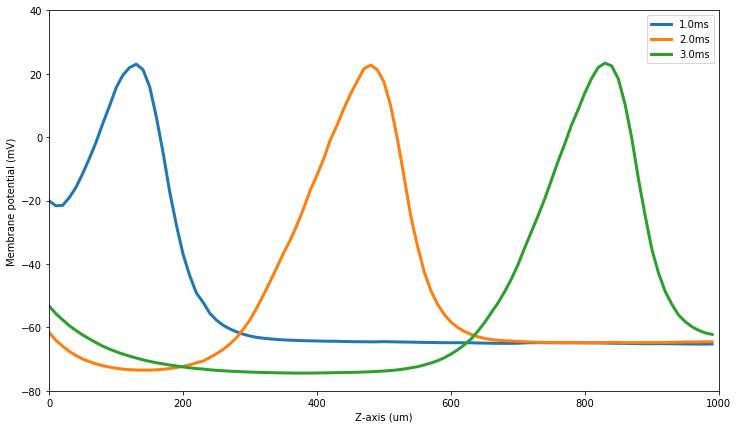

In [42]:
figure(figsize=(12,7))
plotVz(10)
plotVz(20)
plotVz(30)
show()


And to plot the membrane currents along the z-axis also at 1ms, 2ms and 3ms:




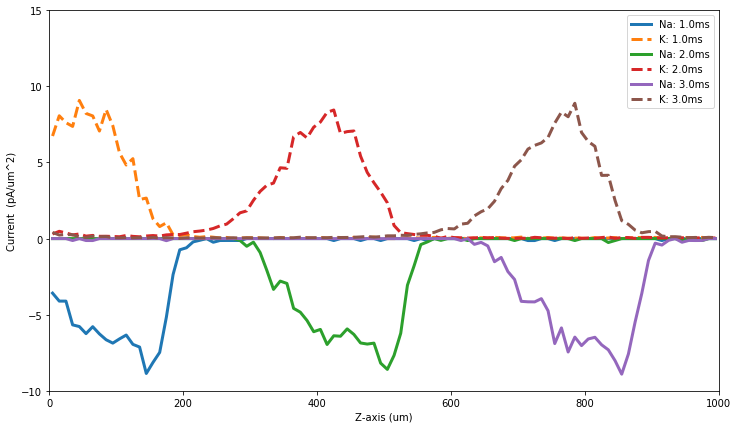

In [43]:
figure(figsize=(12,7))
plotIz(10)
plotIz(20)
plotIz(30)
show()

### Simulation with ``TetOpSplit``

The spatial stochastic approximate solver, which runs in parallel [steps.mpi.solver.TetOpSplit](API_mpi.rst#steps.mpi.solver.TetOpSplit) also supports the membrane potential calculation. The solver is described in detail in a separate chapter, so usage will only
be described briefly here.

Usage is similar as for Tetexact, however we must import some different STEPS modules:




In [44]:
import steps.mpi
import steps.mpi.solver as mpi_solver
import steps.utilities.geom_decompose as gd

-----------------------------------------------------------------
STEPS is running in parallel mode with  1  processes
-----------------------------------------------------------------



We must also partition the mesh along the axis based on the number of MPI hosts:




In [45]:
tet_hosts = gd.binTetsByAxis(mesh, steps.mpi.nhosts)
tri_hosts = gd.partitionTris(mesh, tet_hosts, mesh.getSurfTris())


Now we can create the [steps.mpi.solver.TetOpSplit](API_mpi.rst#steps.mpi.solver.TetOpSplit) solver object, passing the partitioning information
as well as the usual arguments:




In [46]:
sim = mpi_solver.TetOpSplit(mdl, mesh, r, True, tet_hosts, tri_hosts)


This time we only record voltage from the simulation due to the reduced functionality of the solver at present:




In [47]:
sim.setPatchCount('patch', 'Na_m0h0', Na_ro*surfarea*Na_facs[0])
sim.setPatchCount('patch', 'Na_m1h0', Na_ro*surfarea*Na_facs[1])
sim.setPatchCount('patch', 'Na_m2h0', Na_ro*surfarea*Na_facs[2])
sim.setPatchCount('patch', 'Na_m3h0', Na_ro*surfarea*Na_facs[3])
sim.setPatchCount('patch', 'Na_m0h1', Na_ro*surfarea*Na_facs[4])
sim.setPatchCount('patch', 'Na_m1h1', Na_ro*surfarea*Na_facs[5])
sim.setPatchCount('patch', 'Na_m2h1', Na_ro*surfarea*Na_facs[6])
sim.setPatchCount('patch', 'Na_m3h1', Na_ro*surfarea*Na_facs[7])

sim.setPatchCount('patch', 'K_n0', K_ro*surfarea*K_facs[0])
sim.setPatchCount('patch', 'K_n1', K_ro*surfarea*K_facs[1])
sim.setPatchCount('patch', 'K_n2', K_ro*surfarea*K_facs[2])
sim.setPatchCount('patch', 'K_n3', K_ro*surfarea*K_facs[3])
sim.setPatchCount('patch', 'K_n4', K_ro*surfarea*K_facs[4])

sim.setPatchCount('patch', 'Leak', L_ro * surfarea)

sim.setEfieldDT(1.0e-5)

sim.setMembPotential('membrane', -65e-3)
sim.setMembCapac('membrane', 1.0e-2)
sim.setMembVolRes('membrane', 1.0)

# Set the current clamp
niverts = injverts.__len__()
for t in injverts:
    sim.setVertIClamp(t, Iclamp/niverts)

# Create result structures
res = numpy.zeros((N_timepoints, pot_n))
res_I_Na = numpy.zeros((N_timepoints, bins_n))
res_I_K = numpy.zeros((N_timepoints, bins_n))    
    

# Run the simulation
for l in range(N_timepoints):
    if steps.mpi.rank ==0: 
        if l%10 == 0:
            print ("Tpnt: ", l)
    sim.run(DT_sim*l)
    if steps.mpi.rank ==0:
        for p in range(pot_n):
            res[l,p] = sim.getTetV(int(pot_tet[p]))*1.0e3

Tpnt:  0
Tpnt:  10
Tpnt:  20
Tpnt:  30
Tpnt:  40





And simply plot the data:




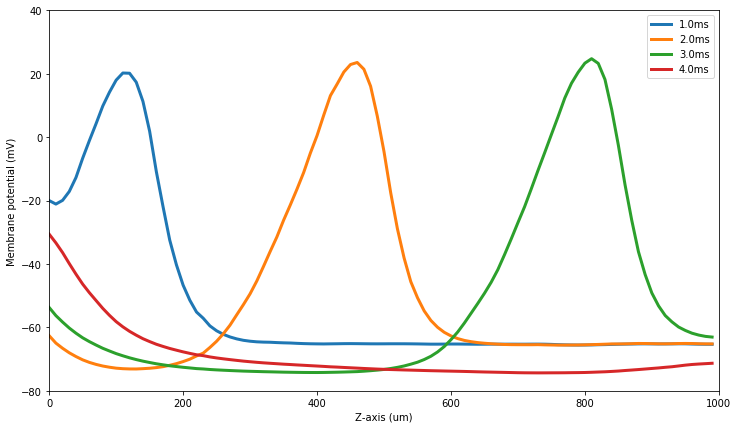

In [48]:
if steps.mpi.rank ==0:
    results = (res,  pot_pos)
    tpnt = arange(0.0, N_timepoints*DT_sim, DT_sim)
    figure(figsize=(12,7))
    for tidx in (10,20,30,40):
        plot(results[1]*1e6, results[0][tidx], \
             label=str(1e3*tidx*DT_sim)+'ms', linewidth=3)
    legend(numpoints=1)
    xlim(0, 1000)
    ylim(-80,40)
    xlabel('Z-axis (um)')
    ylabel('Membrane potential (mV)')
    show()

Assuming that all this script was written in a file named ` HH_APprop_tetopsplit.py`, to run from the command line with 4 MPI processes we should use

    mpirun -n 4 python HH_APprop_tetopsplit.py

### Simulation with ``TetODE``

The spatial deterministic solver [steps.solver.TetODE](API_solver.rst#steps.solver.TetODE), which was introduced in [Simulating Diffusion on Surfaces](surface_diffusion.ipynb), is also available for membrane potential simulations.
As discussed in [Simulating Diffusion on Surfaces](surface_diffusion.ipynb), simulations in TetODE share model and geometry construction with solver Tetexact, with a few
differences to the solver to run deterministic simulations, such as the possibility of setting tolerance levels. Coupling with the membrane potential solution introduces some new considerations. Firstly,
since reaction-diffusion solutions are solved in CVODE this reduces the possibilities of coupling the reaction-diffusion simulation with the membrane
potential calculation. As discussed in [Simulating Diffusion on Surfaces](surface_diffusion.ipynb), a call to [steps.solver.TetODE.run](API_solver.rst#steps.solver.TetODE.run) hands control to CVODE until the specified
endtime during which there can be no communication with the membrane potential calculation. For this reason function `setEfieldDT` is not supported in
TetODE: rather the E-Field time-step is implicitly taken as the simulation time step. E.g. one E-Field calculation will be performed every time the STEPS simulation
is advanced with a call to [steps.solver.TetODE.run](API_solver.rst#steps.solver.TetODE.run). Therefore, in this model, to achieve an E-Field calculation time-step of 0.01ms we need to change
constant ``DT_sim`` to $10^{-5}$, which will also of course change how often we record data, so we need to also change constant ``N_timepoints`` to 401
to ensure we run the simulation to 4ms. If we create a new script called 'HH_APprop_tetode.py' to run the deterministic simulation then, compared to 'HH_APprop.py'
we need to change the following constants:




In [49]:
# The number of simulation time-points
N_timepoints = 401

# The simulation dt, now also the E-Field dt
DT_sim = 1.0e-5 # seconds


And we create a TetODE solver object instead of a Tetexact solver:




In [50]:
sim = ssolver.TetODE(mdl, mesh, r, True)

And remove the unsupported function:

In [51]:
# sim.setEfieldDT(1.0e-5)


Finally, since it is unfortunately not possible to record information about the spatial currents in TetODE (functions such as `getTriOhmicI` are not supported),
we remove anything to do with recording the Na and K currents, which makes our simulation loop rather simple:

In [52]:
sim.setPatchCount('patch', 'Na_m0h0', Na_ro*surfarea*Na_facs[0])
sim.setPatchCount('patch', 'Na_m1h0', Na_ro*surfarea*Na_facs[1])
sim.setPatchCount('patch', 'Na_m2h0', Na_ro*surfarea*Na_facs[2])
sim.setPatchCount('patch', 'Na_m3h0', Na_ro*surfarea*Na_facs[3])
sim.setPatchCount('patch', 'Na_m0h1', Na_ro*surfarea*Na_facs[4])
sim.setPatchCount('patch', 'Na_m1h1', Na_ro*surfarea*Na_facs[5])
sim.setPatchCount('patch', 'Na_m2h1', Na_ro*surfarea*Na_facs[6])
sim.setPatchCount('patch', 'Na_m3h1', Na_ro*surfarea*Na_facs[7])

sim.setPatchCount('patch', 'K_n0', K_ro*surfarea*K_facs[0])
sim.setPatchCount('patch', 'K_n1', K_ro*surfarea*K_facs[1])
sim.setPatchCount('patch', 'K_n2', K_ro*surfarea*K_facs[2])
sim.setPatchCount('patch', 'K_n3', K_ro*surfarea*K_facs[3])
sim.setPatchCount('patch', 'K_n4', K_ro*surfarea*K_facs[4])

sim.setPatchCount('patch', 'Leak', L_ro * surfarea)

sim.setMembPotential('membrane', -65e-3)
sim.setMembCapac('membrane', 1.0e-2)
sim.setMembVolRes('membrane', 1.0)

# Set the current clamp
niverts = injverts.__len__()
for t in injverts:
    sim.setVertIClamp(t, Iclamp/niverts)

# Create result structures
res = numpy.zeros((N_timepoints, pot_n))
res_I_Na = numpy.zeros((N_timepoints, bins_n))
res_I_K = numpy.zeros((N_timepoints, bins_n))    
    


# Run the simulation
for l in range(N_timepoints):
    if steps.mpi.rank ==0: 
        if l%100 == 0:
            print ("Tpnt: ", l)
    sim.run(DT_sim*l)
    for p in range(pot_n):
        res[l,p] = sim.getTetV(int(pot_tet[p]))*1.0e3

Tpnt:  0
Tpnt:  100
Tpnt:  200
Tpnt:  300
Tpnt:  400



And now we return only the information related to the recordings of the spatial membrane potential:



In [53]:
results = (res,  pot_pos)

We can finally plot the results as follows

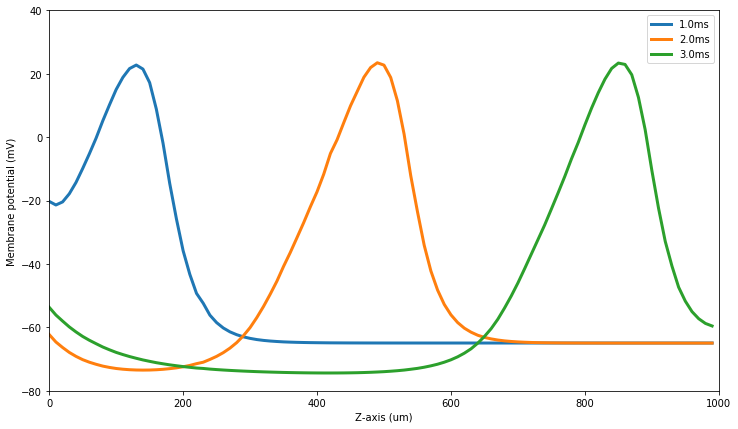

In [54]:
figure(figsize=(12,7))
for tidx in (100,200,300):
    plot(results[1]*1e6, results[0][tidx], \
         label=str(1e3*tidx*DT_sim)+'ms', linewidth=3)
legend(numpoints=1)
xlim(0, 1000)
ylim(-80,40)
xlabel('Z-axis (um)')
ylabel('Membrane potential (mV)')
show()